# MIP model example script

In this notebook, maximum, covolution and ladder of convolutions and maximums can be observed. These version of algorithms are NOT formulated as an optimization problem but rather uses a concrete generated numbers. To see the MIP model that uses optimization variables please see 'example_Optimization.ipynb'.

In [4]:
import src.utility_tools.histogramGenerator as histogramGenerator
import src.timing.infiniteLadder as infiniteLadder 
import numpy as np
from src.timing.ScalingAlgorithms import computeMAPE
import matplotlib.pyplot as plt
import src.timing.SSTA as SSTA
from src.timing.infiniteLadder import putTuplesIntoArray

from src.timing.randomVariableHist_Numpy import RandomVariable

from src.timing.examples_monteCarlo.infinite_ladder_montecarlo import MonteCarlo_inputs, MonteCarlo_nodes, get_moments_from_simulations


from src.utility_tools.node import Node
from tabulate import tabulate
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Maximum

In [5]:
# test max computation

def testMax(numberOfBins, numberOfUnaries):

    mu1 = 12
    sigma1 = 2

    mu2 = 6
    sigma2 = 3

    
    numberOfSamples = 20000000
    interval = (3, 20)

    # DESIRED

    rv1 = np.random.normal(mu1, sigma1, numberOfSamples)
    rv2 = np.random.normal(mu2, sigma2, numberOfSamples)

    max1 = np.maximum(rv1, rv2)
    desired = np.array([np.mean(max1), np.std(max1)])


    # ACTUAL

    # histogram1
    h1 = histogramGenerator.get_gauss_bins_UNARY(mu1, sigma1, numberOfBins, numberOfSamples, interval, numberOfUnaries)
    h2 = histogramGenerator.get_gauss_bins_UNARY(mu2, sigma2, numberOfBins, numberOfSamples, interval, numberOfUnaries)

    max2 = h1.maxOfDistributionsQUAD_FORMULA_UNARY(h2)

    actual = np.array([max2.mean, max2.std])

        # debug plotting
    import matplotlib.pyplot as plt
    h1 = histogramGenerator.get_Histogram_from_UNARY(h1)
    h2 = histogramGenerator.get_Histogram_from_UNARY(h2)
    max2 = histogramGenerator.get_Histogram_from_UNARY(max2)
    
    plt.hist(max2.edges[:-1], max2.edges, weights=max2.bins)
    _ = plt.hist(max1, bins=numberOfBins, density='PDF', alpha=0.8)
    plt.legend(["Unary encoding", "Monte Carlo"])
    
    
    return (actual, desired)

[12.08142578  1.92823716] [12.07256116  1.95000626]
[0.0734278  1.11636049]


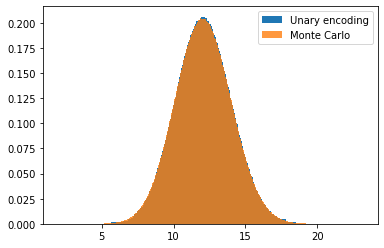

In [6]:
# test max as wanted

numberOfBins = 500
numberOfUnaries = 500




# plot error
actual, desired = testMax(numberOfBins, numberOfUnaries)
MAPE = 100 * np.abs((actual - desired) / desired)


print(actual, desired)
print(MAPE)

### Convolution

In [7]:
def testConvolution(numberOfBins, numberOfUnaries):

    mu1 = 7
    sigma1 = 2

    mu2 = 10
    sigma2 = 1

    
    numberOfSamples = 20000000

    interval = (-5, 40)

    # DESIRED

    rv1 = np.random.normal(mu1, sigma1, numberOfSamples)
    rv2 = np.random.normal(mu2, sigma2, numberOfSamples)

    max1 = rv1 + rv2
    desired = np.array([np.mean(max1), np.std(max1)])


    # ACTUAL

    # histogram1
    h1 = histogramGenerator.get_gauss_bins_UNARY(mu1, sigma1, numberOfBins, numberOfSamples, interval, numberOfUnaries)
    h2 = histogramGenerator.get_gauss_bins_UNARY(mu2, sigma2, numberOfBins, numberOfSamples, interval, numberOfUnaries)

    
    rv1 = histogramGenerator.get_gauss_bins(mu1, sigma1, numberOfBins, numberOfSamples, interval)
    rv2 = histogramGenerator.get_gauss_bins(mu2, sigma2, numberOfBins, numberOfSamples, interval)

    
    max2 = h1.convolutionOfTwoVarsNaiveSAME_UNARY(h2)

    actual = np.array([max2.mean, max2.std])

    
    import matplotlib.pyplot as plt
    h1 = histogramGenerator.get_Histogram_from_UNARY(h1)
    h2 = histogramGenerator.get_Histogram_from_UNARY(h2)
    max2 = histogramGenerator.get_Histogram_from_UNARY(max2)
    
    plt.hist(max2.edges[:-1], max2.edges, weights=max2.bins)
    _ = plt.hist(max1, bins=numberOfBins, density='PDF', alpha=0.7)
    
    return (actual, desired)

[17.15285714  2.11639663] [16.99986693  2.23603878]
[0.89994948 5.35062969]


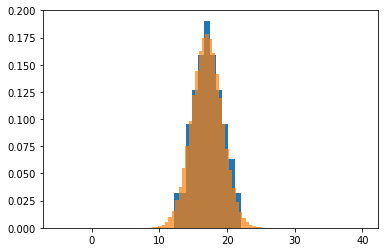

In [8]:
# test convolution as wanted

numberOfBins = 50
numberOfUnaries = 50
actual, desired = testConvolution(numberOfBins, numberOfUnaries)


# plot error
MAPE = 100 * np.abs((actual - desired) / desired)

print(actual, desired)
print(MAPE)

### Ladder of maximum and convolutions

In [9]:
def LadderNumpy(numberOfBins=100, numberOfUnaries=100, number_of_nodes=1, interval=(-3, 15)):

    n_samples = 2000000
    seed = 0

    gateParams = [0.0, 1.0]

    # fix a random seed seed exists
    if seed != None:
        seed = seed
        np.random.seed(seed)

        
    ####################################
    ####### Generate Input data ########
    ####################################

    # list with inputs' mean values
    input_means = [np.random.randint(20, 70) / 10 for _ in range(number_of_nodes + 1)]
    # list with inputs' stds
    input_stds = [np.random.randint(20, 130) / 100 for _ in range(number_of_nodes + 1)]

#     input_means = [7, 10]
#     input_stds = [2, 1]
    
    # CVXPY

    constraints = []

    # generate inputs
    startingNodes = []
    for i in range(0, number_of_nodes + 1):
        g = histogramGenerator.get_gauss_bins_UNARY(input_means[i], input_stds[i], numberOfBins, n_samples,
                                                    interval, numberOfUnaries)

        node = Node(g)
        startingNodes.append(node)

        # generetate nodes
    generatedNodes = []
    for i in range(0, number_of_nodes):
        g = histogramGenerator.get_gauss_bins_UNARY(gateParams[0], gateParams[1], numberOfBins, n_samples, interval,
                                                    numberOfUnaries)

        node = Node(g)
        generatedNodes.append(node)

    # set circuit design

    # start
    startingNodes[0].setNextNodes([generatedNodes[0]])

    # upper part
    for i in range(1, number_of_nodes + 1):
        start = startingNodes[i]
        start.setNextNodes([generatedNodes[i - 1]])

        # lower part
    for i in range(0, number_of_nodes - 1):
        node = generatedNodes[i]
        node.setNextNodes([generatedNodes[i + 1]])

    delays = SSTA.calculateCircuitDelay(startingNodes, cvxpy=False, unary=True)

    delays = delays[number_of_nodes + 1:]

    rvs = []

    for gate in range(0, number_of_nodes):  # construct RVs

        finalBins = np.zeros((numberOfBins, numberOfUnaries))
        for bin in range(0, numberOfBins):
            for unary in range(0, numberOfUnaries):
                finalBins[bin, unary] = ((delays[gate].bins)[bin])[unary]

        rvs.append(RandomVariable(finalBins, generatedNodes[0].randVar.edges, unary=True))

    # simulate inputs
    nodes_simulation = [0 for _ in range(number_of_nodes)]
    inputs_simulation = MonteCarlo_inputs(input_means, input_stds, n_samples, 'Normal')

    # traverse the circuit
    nodes_simulation[0] = MonteCarlo_nodes(inputs_simulation[0], inputs_simulation[1], gateParams, n_samples)
    for i in range(1, number_of_nodes):
        nodes_simulation[i] = MonteCarlo_nodes(nodes_simulation[i - 1], inputs_simulation[i + 1], gateParams,
                                               n_samples)

    desired = get_moments_from_simulations(nodes_simulation)
    import matplotlib.pyplot as plt
    max2 = histogramGenerator.get_Histogram_from_UNARY(rvs[-1])
    
    plt.hist(max2.edges[:-1], max2.edges, weights=max2.bins)
    _ = plt.hist(nodes_simulation[-1], bins=numberOfBins, density='PDF', alpha=0.7)
        
    return np.array([rvs[-1].mean, rvs[-1].std]), np.array(desired[0])


[6.75485108 1.52727709] [7.05571058 1.23373662]
[ 4.26405665 23.79279896]


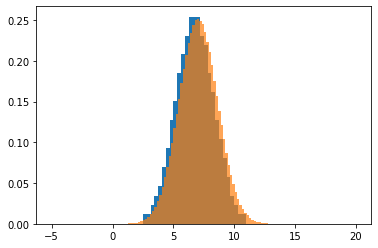

In [10]:
numberOfNodes = 2

numberOfBins = 80
numberOfUnaries = 80

interval = (-5, 20)



# plot error
actual, desired = LadderNumpy(numberOfBins, numberOfUnaries, numberOfNodes, interval=interval)
MAPE = 100 * np.abs((actual - desired) / desired)

print(actual, desired)
print(MAPE)